<a href="https://colab.research.google.com/github/koinav/EDA_Netflix/blob/main/EDA_Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Описание задания

Netflix за последние 5-10 лет обзавелись большим количеством зрителей. С увеличением числа зрителей увеличилось и разнообразие шоу. Соответственно, перед аналитиками из киноиндустрии встала задача исследования данных с рейтингами различных сериалов.

В данном задании нам предстоит провести визуальный анализ датасета 1000 Netflix Shows (по состоянию на 11.06.2017) и сделать выводы.

#### Описание признаков

* `title` - название шоу.
* `rating` - рейтинг шоу. Например: G, PG, TV-14, TV-MA.
* `ratingLevel` - описание рейтинговой группы и особенностей шоу.
* `ratingDescription` - рейтинг шоу, закодированный числом.
* `release year` - год выпуска шоу.
* `user rating score` - оценка пользователей.
* `user rating size` - общий рейтинг пользователей.

#### Загрузка данных

Импортируем данные и загрузим датасет.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import matplotlib.patches as mpatches

In [ ]:
data = pd.read_excel("NetflixShows.xlsx")
del data['ratingDescription'], data['user rating size']

In [ ]:
# Приведем все данные к одному виду
data = data.rename(columns={
    'ratingLevel' : 'rating_level',
    'release year' : 'release_year',
    'user rating score' : 'user_rating_score'
})

In [ ]:
data.head(5)

,title,rating,rating_level,release_year,user_rating_score
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",2004,82.0
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",2006,NaN
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,2016,98.0
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,2008,98.0
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,2014,94.0


### Обработка дубликатов

In [ ]:
# Посчитаем количество полных дубликатов
data.duplicated().sum()

500

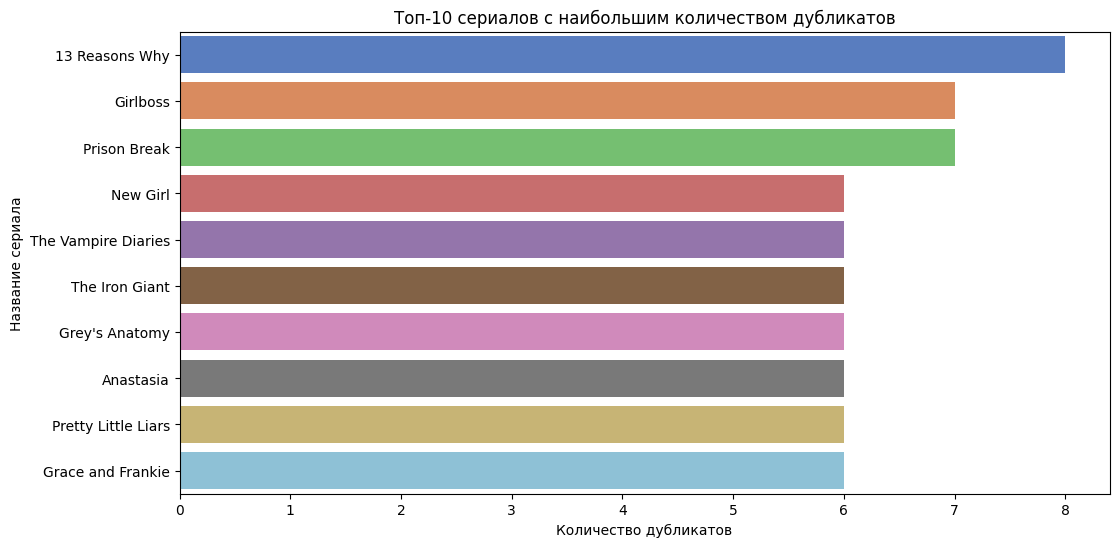

In [ ]:
duplicates_count = data.groupby('title').size().reset_index(name='count')
duplicates_count = duplicates_count.sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='title', hue='title',
            data=duplicates_count.head(10), palette='muted')
plt.title('Топ-10 сериалов с наибольшим количеством дубликатов')
plt.xlabel('Количество дубликатов')
plt.ylabel('Название сериала')
plt.show()

In [ ]:
data[data.title == '13 Reasons Why']

,title,rating,rating_level,release_year,user_rating_score
41,13 Reasons Why,TV-MA,For mature audiences. May not be suitable for...,2017,99.0
141,13 Reasons Why,TV-MA,For mature audiences. May not be suitable for...,2017,99.0
189,13 Reasons Why,TV-MA,For mature audiences. May not be suitable for...,2017,99.0
241,13 Reasons Why,TV-MA,For mature audiences. May not be suitable for...,2017,99.0
295,13 Reasons Why,TV-MA,For mature audiences. May not be suitable for...,2017,99.0
347,13 Reasons Why,TV-MA,For mature audiences. May not be suitable for...,2017,99.0
396,13 Reasons Why,TV-MA,For mature audiences. May not be suitable for...,2017,99.0
497,13 Reasons Why,TV-MA,For mature audiences. May not be suitable for...,2017,99.0


Дубликатов много. Например, сериал "13 Reasons Why" встречается в подборке целых 8 раз. Можно было бы предположить, что сериалы попадали туда каждый раз, когда на платформу добавлялся новый сезон. Однако заметим, что в нашем датасете количество сезонов сериала зачастую не совпадает с количеством его дубликатов.

В ходе дальнейшего исследования выяснилось, что для сбора данных использовался рекомендационный движок Netflix. Автором было выбрано 4 видео из 4 различных рейтингов (итого 16 уникальных шоу), а затем для каждого видео собирались дальнейшие рекомендации.


Это наталкивает на идею исследовать алгоритм составления рекомендаций сервисом. Проверим, зависит ли частота появления того или иного шоу в рекомендациях от его пользовательской оценки.

In [ ]:
# Сделаем датасет без пропусков в столбце 'user_rating_score'
data_clean = data.dropna(subset=['user_rating_score'])

In [ ]:
# Сгруппируем шоу по частоте их вхождения в датасет и их пользовательской оценке
freq_data = data_clean.groupby('title').agg(
  frequency=('title', 'size'),
  user_rating_score=('user_rating_score', 'first')
).reset_index()

freq_data.head()

,title,frequency,user_rating_score
0,90210,3,62.0
1,10 Things I Hate About You,1,68.0
2,13 Reasons Why,8,99.0
3,30 Rock,2,66.0
4,Absolutely Fabulous,1,59.0


In [ ]:
# Сделаем scatter plot и добавим линию тренда
fig_trend = px.scatter(
    freq_data,
    x='user_rating_score',
    y='frequency',
    hover_data=['title'],
    trendline='ols',
    title='Зависимость частоты появления сериала от его средней оценки с трендовой линией',
    labels={
        'user_rating_score': 'Средняя оценка пользователей',
        'frequency': 'Частота появления сериала'
    },
    template='plotly_white'
)

fig_trend.update_traces(selector=dict(mode='markers'), marker=dict(size=10, color='salmon'))


# Подпишем корреляцию
corr_value = np.corrcoef(freq_data['user_rating_score'], freq_data['frequency'])[0, 1]

fig_trend.add_annotation(
    xref="paper",
    yref="paper",
    x=0.05,
    y=0.95,
    text=f"Корреляция: {corr_value:.2f}",
    showarrow=False,
    font=dict(size=12, color="black"),
    bgcolor="white",
    bordercolor="black"
)

fig_trend.show()

По данной визуализации можно сделать следующие выводы:

* Умеренная положительная корреляция (0.34) между частотой появления сериала и его средней оценкой говорит о том, что Netflix действительно рекомендует популярные и высоко оцененные шоу чаще. Однако связь не является сильной, что указывает на роль других факторов в алгоритме рекомендаций (жанры, пользовательские предпочтения, локализация и т.д.). Можно также оценить влияние рейтинга, но для детального анализа нам потребуется больше данных.

* С таким уровнем зависимости от оценки алгоритм может вызвать риск того, что менее оцененные сериалы будут теряться на платформе. Так, потенциально хороший сериал, получивший несколько невысоких оценок при выходе (например, из-за какого-то скандала) рискует сильно ухудшить свои позиции в дальнейшем.


In [ ]:
# Удалим дубликаты
data = data.drop_duplicates()
data.reset_index(drop=True, inplace=True)
data.shape

(500, 5)

In [ ]:
# Посмотрим на дубликаты в колонке 'title'
duplicates = data[data["title"].duplicated(keep=False)]

duplicates

,title,rating,rating_level,release_year,user_rating_score
119,Skins,TV-MA,For mature audiences. May not be suitable for...,2013,NaN
128,Bordertown,TV-14,Parents strongly cautioned. May be unsuitable ...,2016,86.0
135,Skins,TV-MA,NaN,2017,NaN
257,Bordertown,TV-MA,For mature audiences. May not be suitable for...,2016,NaN
269,Star Wars: The Clone Wars,PG,"sci-fi action violence throughout, brief langu...",2008,57.0
276,Star Wars: The Clone Wars,TV-PG,Parental guidance suggested. May not be suitab...,2014,93.0
321,Goosebumps,TV-Y7,Suitable for children ages 7 and older,1998,88.0
366,Goosebumps,PG,"scary and intense creature action and images, ...",2015,90.0


Можно заметить, что, несмотря на то, что полные дубликаты мы удалили, в таблице остались столбцы с одинаковыми названиями шоу. Многие дубликаты имеют различные рейтинги, годы выхода и оценки. Скорее всего это разные шоу с одинаковыми названиями, либо разные версии одного и того же шоу (например, обычная и расширенная). Так что от дубликатов по названию избавляться не будем. Остальные же столбцы анализировать на дубликаты не имеет смысла.

### Univariate-анализ

Перейдем непосредственно к анализу нашего датасета. Начнем с анализа каждого признака по отдельности.

#### Анализ шоу по рейтингам

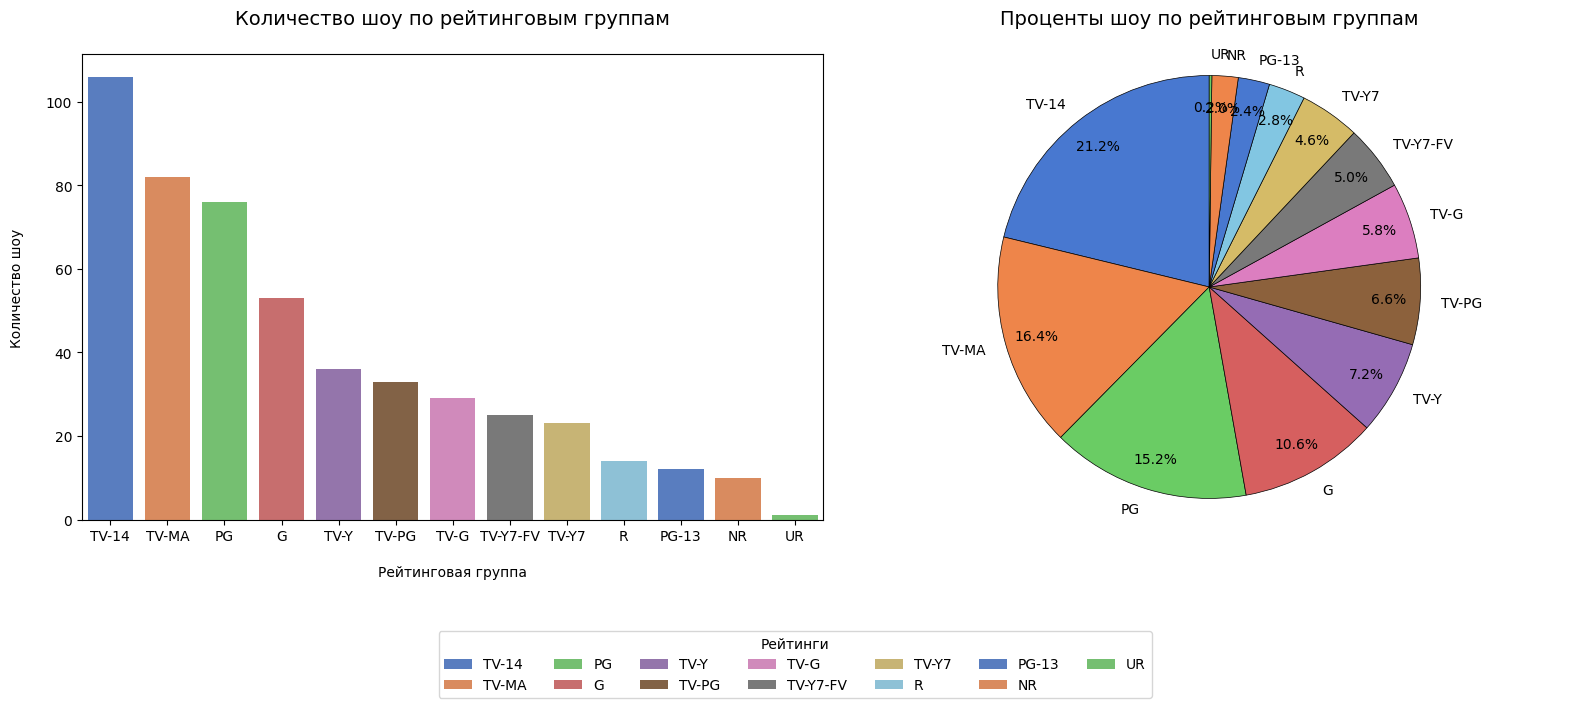

In [ ]:
# Определяем порядок рейтингов
rating_order = data['rating'].value_counts().index

# Создаем для них палитру цветов и считаем проценты
palette = sns.color_palette('muted', n_colors=len(rating_order))
ratings_dist = data['rating'].value_counts(normalize=True).loc[rating_order] * 100


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Столбчатая диаграмма
sns.countplot(
    data=data,
    x='rating',
    hue='rating',
    order=rating_order,
    hue_order=rating_order,
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("Количество шоу по рейтинговым группам\n", fontsize=14)
axes[0].set_xlabel("\nРейтинговая группа")
axes[0].set_ylabel("Количество шоу\n")

# Круговая диаграмма
axes[1].pie(
    ratings_dist,
    labels=ratings_dist.index,
    autopct='%.1f%%',
    startangle=90,
    colors=palette,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}
)
axes[1].set_title("Проценты шоу по рейтинговым группам\n", fontsize=14)
axes[1].axis('equal')

fig.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    title="Рейтинги",
    labels=[l for l in ratings_dist.index],
    ncol=7
)

plt.tight_layout()
plt.show()

*Мы видим, что в рейтингах наибольшее количество шоу из группы TV-14, Это шоу предназначено для людей, старше 14 лет. Это обусловлено, вероятно, тем, что данные шоу смотрит большое количество подростков, а они более склонны к тому, чтоб оставить отзыв понравившемуся фильму ввиду их эмоциональной подвижности, а также ввиду того, что подростки являются более активными пользователями интернета. На втором месте находятся шоу, требующие родительского контроля, а на третьем месте находятся шоу с возрастным ограничением 17 лет. Можно заметить, что шоу с низким возрастным ограничением имеют меньшее количество упоминаний в рейтингах. Это, вероятно, связано с тем, что дети малого возраста не могут оставить отзыв, а более старшая аудитория менее склонна к просмотру подобного контента.*

#### Анализ шоу по годам

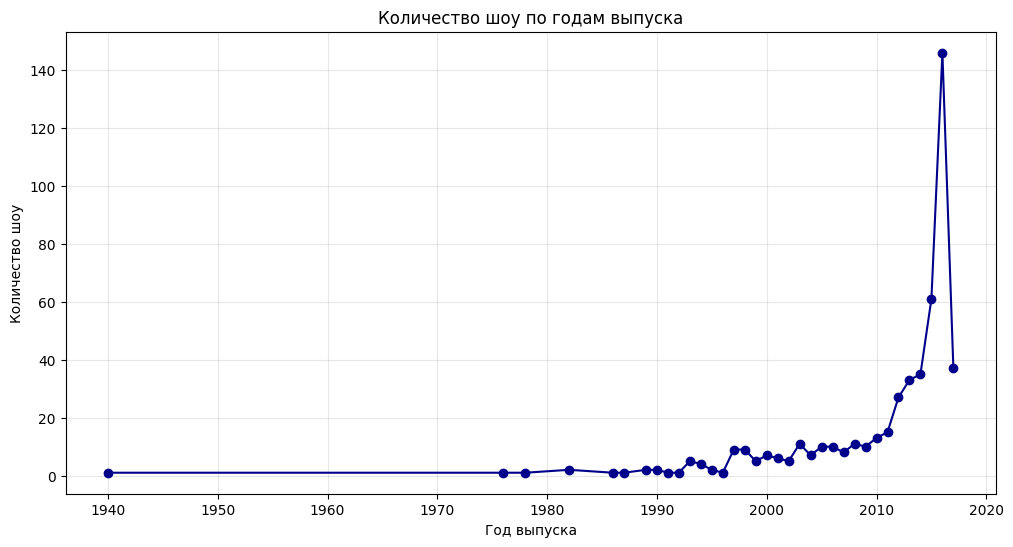

In [ ]:
show_counts = data['release_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(show_counts.index, show_counts.values, marker='o', color='darkblue')
plt.title('Количество шоу по годам выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Количество шоу')
plt.grid(alpha=0.3)
plt.show()

*Стабильный рост наблюдается на всем протяжении графика. Однако с 2010 года можно выделить кратное ускорение темпов роста. Это может быть связано как в целом с развитием киноиндустрии и повышением доступности кинематографа, так и с развитием самой компании и запуском внутри нее новых эксклюзивных проектов собственного производства.*

*Пик количества выпущенных шоу приходится на 2016 год, превышая значение предыдущего года почти в 2.5 раза. В 2017 году заметен сильный спад, но причина здесь наверняка в самих данных: датасет собирался посреди 2017 года и многие вышедшие в том же году проекты туда не попали. Из-за нехватки данных сложно сделать вывод, являются ли результаты 2016 года выбросом, или скорее закономерным продолжением роста. Зато одинокий мультфильм из 1940 года точно можно назвать выбросом.*


#### Анализ оценок

In [ ]:
# Выберем только шоу, для которых известна оценка
ratings_clean = data.dropna(subset=['user_rating_score'])
print('Всего шоу с оценками:', ratings_clean['user_rating_score'].count())

Всего шоу с оценками: 256


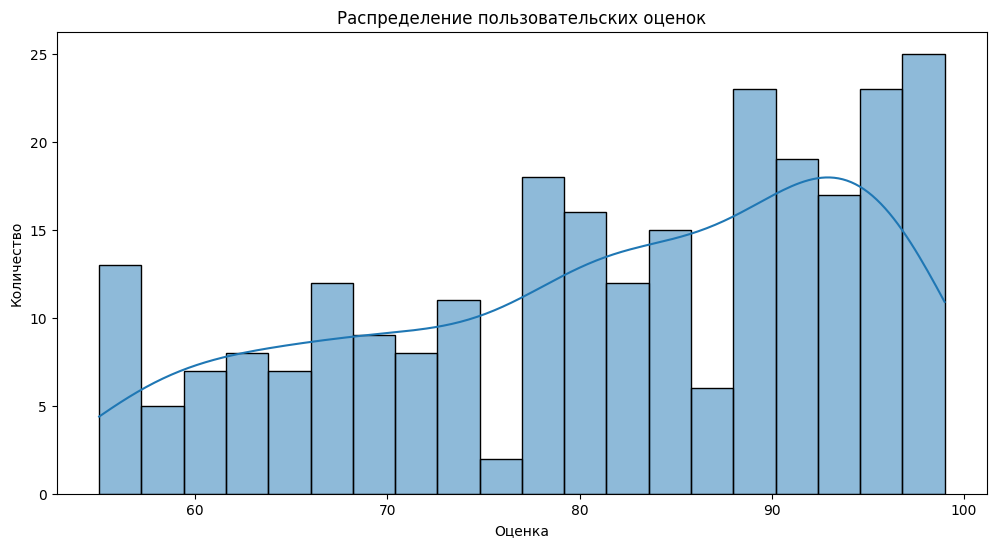

In [ ]:
# Посмотрим на распределение оценок
plt.figure(figsize=(12, 6))
sns.histplot(ratings_clean['user_rating_score'], bins=20, kde=True)
plt.title('Распределение пользовательских оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

*Есть 2 объяснения, почему такие оценки могут быть самыми популярными:*

* **Селективность аудитории**

*Люди, которые оставляют оценки, часто являются поклонниками произведения и стараются таким образом поддержать проект. Те, кому сериал не понравился, реже утруждаются оставить отзыв. Если, конечно, они не испытали явно негативных эмоций и не решили поставить самую негативную оценку (можно обратить внимание на размер самого левого бара и его отличие от соседних).*

* **Эффект группового мнения**

*Если несколько первых обозревателей выставили высокие оценки, другие пользователи могут бессознательно ориентироваться на них, подтверждая общую тенденцию положительных оценок. Также зачастую обычного зрителя куда проще удивить, чем профессионала в данной области, поэтому пользовательские оценки обычно выше оценок критиков.*

### Multivariate-анализ

Далее перейдем к более продвинутому анализу. Сначала посмотрим на то, как менялась средняя пользовательская оценка по годам выпуска шоу и подумаем, достаточно ли данной информации для того, чтобы сделать какие-то выводы.

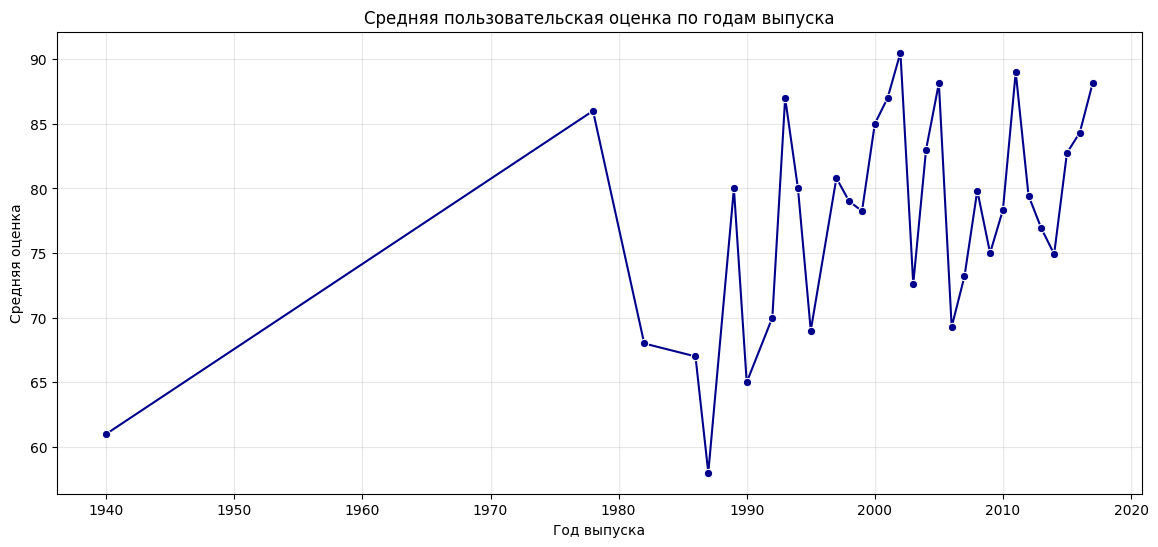

In [ ]:
yearly_avg = ratings_clean.groupby('release_year')['user_rating_score'].mean().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data=yearly_avg, x='release_year', y='user_rating_score', marker='o', color='darkblue')
plt.title('Средняя пользовательская оценка по годам выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя оценка')
plt.grid(alpha=0.3)
plt.show()

Так выглядить распределение средних пользовательских оценок по годам. Попробуем провести анализ на примере сравнения успешности 2016 и 2017 годов.

In [ ]:
print(f"Средний рейтинг за 2016 год: {ratings_clean[ratings_clean.release_year == 2016].user_rating_score.mean()}")
print(f"Средний рейтинг за 2017 год: {ratings_clean[ratings_clean.release_year == 2017].user_rating_score.mean()}")
print()
print(f"Количество шоу с оценками за 2016 год: {ratings_clean[ratings_clean.release_year == 2016].user_rating_score.count()}")
print(f"Количество шоу с оценками за 2017 год: {ratings_clean[ratings_clean.release_year == 2017].user_rating_score.count()}")

Средний рейтинг за 2016 год: 84.31395348837209
Средний рейтинг за 2017 год: 88.125

Количество шоу с оценками за 2016 год: 86
Количество шоу с оценками за 2017 год: 16


*В 2017 году средняя пользовательская оценка выросла почти на 4 балла, что можно считать довольно существенным прогрессом относительно предыдущего года. Однако, если посмотреть на количество шоу, выпущенных в данные годы, можно заметить кратное различие. Стоит учитывать, что данные собраны на куда меньшей выборке, о чем мы уже говорили ранее. Поэтому сложно считать данное сравнение полностью корректным.*

Для большей наглядности отобразим на одном графике количество оценок и среднюю оценку по годам и попробуем определить, возможно ли на основе данной выборки делать какие-либо достоверные выводы.

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

no1940 = ratings_clean[ratings_clean["release_year"] != 1940]

# Cредняя оценка по годам
yearly_avg = no1940.groupby("release_year", as_index=False)["user_rating_score"].mean()
yearly_avg.rename(columns={"user_rating_score": "avg_rating"}, inplace=True)

# Кол-вл шоу по годам
yearly_count = no1940.groupby("release_year", as_index=False)["user_rating_score"].count()
yearly_count.rename(columns={"user_rating_score": "num_shows"}, inplace=True)

yearly_stats = pd.merge(yearly_avg, yearly_count, on="release_year")

# Немного нормализуем кол-во шоу по годам
yearly_stats["num_shows_normalized"] = yearly_stats["num_shows"] ** 0.8 * 2

fig = make_subplots()

# Средняя оценка по годам
fig.add_trace(
    go.Scatter(
        x=yearly_stats["release_year"],
        y=yearly_stats["avg_rating"],
        mode="lines+markers",
        name="Средняя оценка",
        line=dict(color="blue", width=2),
        marker=dict(size=6)
    )
)

# Кол-во фильмов по годам
fig.add_trace(
    go.Bar(
        x=yearly_stats["release_year"],
        y=yearly_stats["num_shows_normalized"],
        name="Количество фильмов",
        marker_color="orange",
        opacity=0.6,
        text=yearly_stats["num_shows"],
        textposition="outside"
    )
)

fig.update_layout(
    title="Средняя оценка и количество фильмов по годам",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(x=0.02, y=0.98),
    yaxis_title="Средняя оценка"
)

fig.update_xaxes(title_text="Год выпуска")

fig.show()

Как можно заметить, большинство годов включает в себя слишком маленькое количество шоу, которого недостаточно для полноценного и обоснованного анализа. Какое-то удовлетворительное количество начинается только с 2012 года и в данный период можно отметить тренд на рост средней оценки, что может говорить о повышении качества проектов, представленных на платформе.

Продолжим наш анализ. Попробуем проанализировать, шоу из каких рейтинговых групп получают наивысшие оценки, и сравним эти данные с трендами в индустрии. Для анализа будем брать данные начиная с 2012 года по причинам, изложенным выше.

In [ ]:
ratings_from_2012 = ratings_clean[ratings_clean['release_year'] >= 2012]

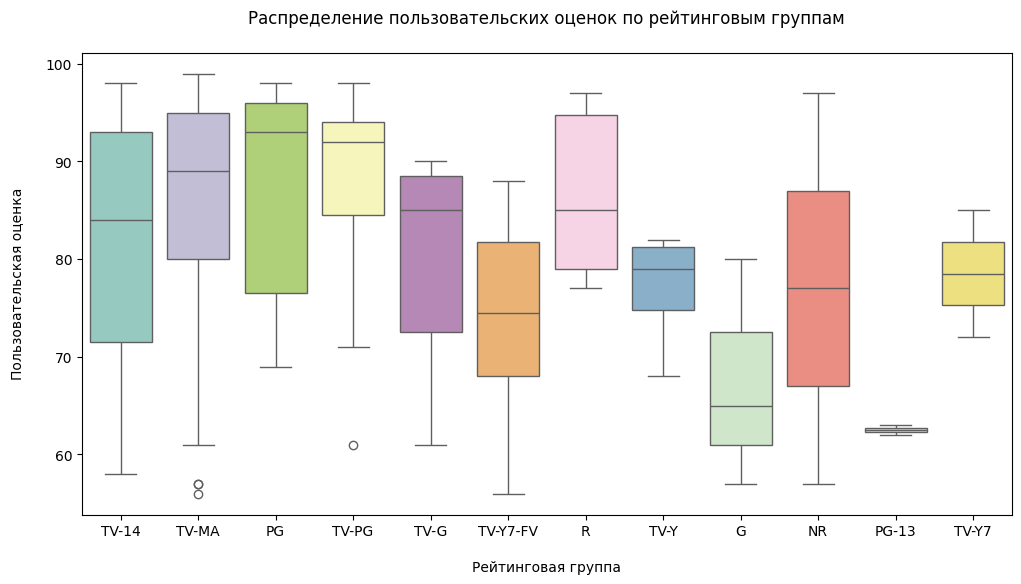

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=ratings_from_2012, x='rating', hue='rating', y='user_rating_score',
            order=ratings_from_2012['rating'].value_counts().index, palette='Set3')

plt.title("Распределение пользовательских оценок по рейтинговым группам\n")
plt.xlabel("\nРейтинговая группа")
plt.ylabel("Пользовательская оценка\n")
plt.show()

Сделаем выводы по данной визуализации:

* Наибольший разброс по значениям можно наблюдать у шоу из категорий TV-14 и TV-MA, а также NR. Это говорит о том, что проекты, рассчитанные на более зрелую аудиторию, чаще вызывают противоречивые чувства и могут чаще получать негативные оценки, однако медианная оценка все еще остается довольно высокой, что говорит о любви публики к данного рода контенту.

* Категория R сочетает в себе высокую медиану предыдущих категорий и низкий разброс, что может означать, что к данной категории публика относится наиболее лояльно и тепло.

* Категории PG и G традиционно рассчитаны на широкий круг зрителей. Они имеют стабильные оценки, но не превышают показатели наиболее успешных категорий. Это подтверждает их роль как "семейного" контента, сохраняющего лояльность широкой аудитории.

* Особенно низкие оценки наблюдаются у некоторых детских категорий, таких как G, TV-Y7-FV и похожих. Это может быть связано с жесткой конкуренцией или нехваткой контента высокого качества в данном сегменте.



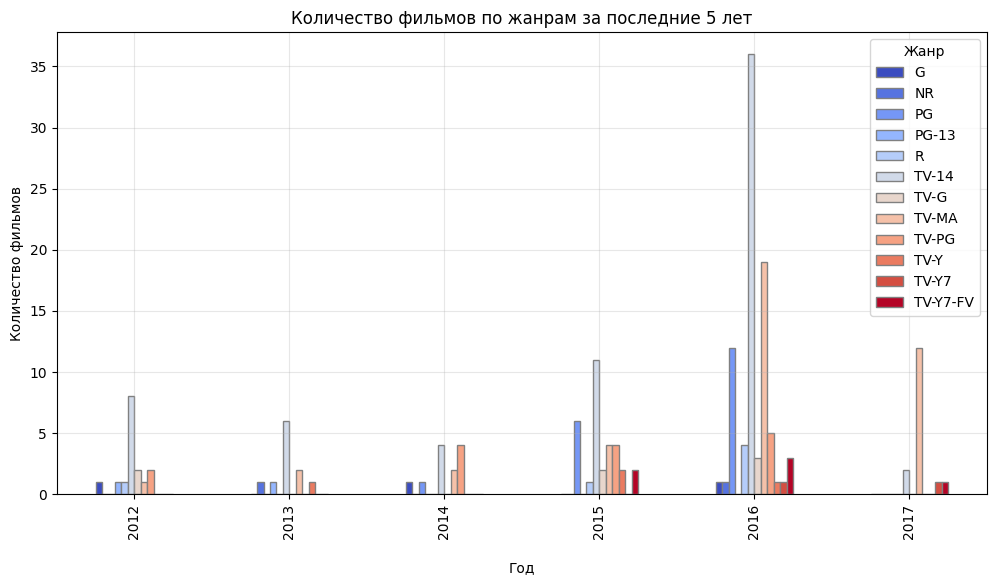

In [ ]:
count_data = ratings_from_2012.groupby(['release_year', 'rating']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))

count_data.plot(kind='bar', colormap='coolwarm', ax=ax)

for patch in ax.patches:
    patch.set_edgecolor("gray")
    patch.set_linewidth(1)

ax.set_xlabel('\nГод')
ax.set_ylabel('Количество фильмов')
ax.set_title('Количество фильмов по жанрам за последние 5 лет')
ax.legend(title='Жанр')
ax.grid(alpha=0.3)

plt.show()

Данная визуализация поможет нам сопоставить тренды по выпуску контента с оценками пользователей. Можно заметить, что тренды по выпуску шоу отражают картину популярности среди пользователей.

### Добавление признаков

*Заметим, что рейтинговая группа нам может помочь определить тип шоу: фильм или сериал. Если в столбце 'rating' значение начинается с TV, то это сериал, если нет - фильм.*

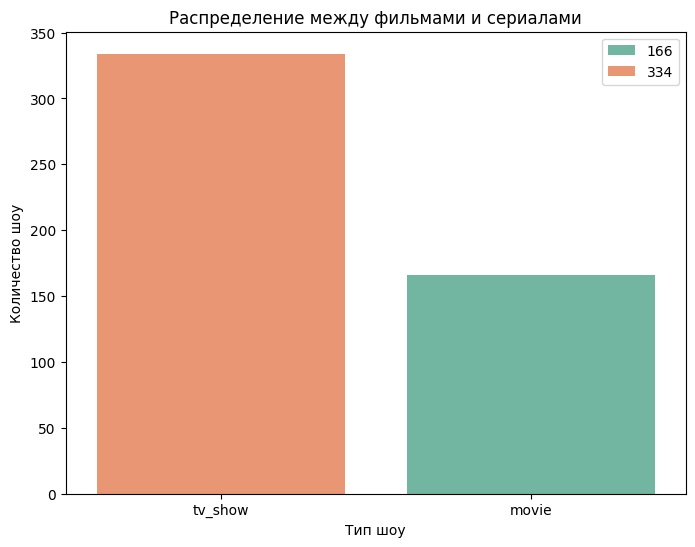

In [ ]:
data['show_type'] = ['tv_show' if 'TV' in rating else 'movie' for rating in data['rating']]

plt.figure(figsize=(8, 6))
sns.barplot(x=data['show_type'].value_counts().index, y=data['show_type'].value_counts().values, hue=data['show_type'].value_counts().values, palette='Set2')

plt.title('Распределение между фильмами и сериалами')
plt.xlabel('Тип шоу')
plt.ylabel('Количество шоу')
plt.show()

Выводы по графику

1. Сериалов (334) больше, чем фильмов (166), что отражает предпочтения аудитории.  
2. Компаниям выгоднее сосредоточиться на сериалах для удовлетворения спроса.  
3. Сериалы лучше удерживают зрителей благодаря глубоким сюжетам и длительной вовлеченности.  

Рекомендации

- Увеличить инвестиции в сериалы.  
- Использовать аналитику для продвижения и персонализации контента.

In [ ]:
# Фильтруем записи с наличием оценок
df_ratings = data.dropna(subset=['user_rating_score'])
df_ratings = df_ratings[df_ratings["release_year"] != 1940]

# Строим график с линией тренда
fig = px.scatter(
    df_ratings,
    x="release_year",
    y="user_rating_score",
    color="rating",   # разбивка по возрастным ограничениям
    symbol="show_type",     # различаем фильмы и сериалы
    hover_data=["title"],
    trendline="ols",        # добавление линии тренда методом наименьших квадратов
    title="Динамика пользовательских оценок по годам с линией тренда"
)

fig.update_layout(xaxis_title="Год выпуска", yaxis_title="User Rating Score")
fig.show()

# Для получения статистических параметров модели (например, коэффициента корреляции)
trendline_results = px.get_trendline_results(fig)
print(trendline_results)


      rating show_type                                     px_fit_results
0      PG-13     movie  <statsmodels.regression.linear_model.Regressio...
1      TV-14   tv_show  <statsmodels.regression.linear_model.Regressio...
2      TV-PG   tv_show  <statsmodels.regression.linear_model.Regressio...
3      TV-MA   tv_show  <statsmodels.regression.linear_model.Regressio...
4         NR     movie  <statsmodels.regression.linear_model.Regressio...
5       TV-Y   tv_show  <statsmodels.regression.linear_model.Regressio...
6   TV-Y7-FV   tv_show  <statsmodels.regression.linear_model.Regressio...
7         PG     movie  <statsmodels.regression.linear_model.Regressio...
8          R     movie  <statsmodels.regression.linear_model.Regressio...
9       TV-G   tv_show  <statsmodels.regression.linear_model.Regressio...
10         G     movie  <statsmodels.regression.linear_model.Regressio...
11     TV-Y7   tv_show  <statsmodels.regression.linear_model.Regressio...


Динамика пользовательских оценок демонстрирует широкий разброс от 60 до 100, с преобладанием в диапазоне 70-90. На телевизионные шоу и фильмы в разных возрастных категориях пользовательские оценки влияют по-разному.

1. Типы контента и оценки: Телевизионные шоу, такие как "TV-Y7", показывают улучшение оценок, тогда как "TV-14" более нестабильны. Фильмы в категориях "PG", "R" имеют в основном стабильные оценки, с некоторым ростом или спадом в отдельных категориях.

2. Тренды и временные переходы: До 2010 года наблюдается сгущение оценок, указывающее на рост популярности контента и увеличение предложения.

3. Возрастные рейтинги и тренды: Семейные категории ("G", "TV-Y") показывают стабильный или положительный рост оценок, а более взрослые категории ("TV-MA", "R") демонстрируют менее стабильные, но местами растущие тренды.

Бизнес-выводы:

- Фокус на детский и семейный контент может стабильно улучшать рейтинги.
- Внимание к более зрелым категориям следует уделять, чтобы повысить стабильность оценок.
- Увеличение контента с положительной динамикой рейтинга способно повысить лояльность и привлечь более широкую аудиторию.

Далее поработаем конкретно с сериалами и фильмами производства Netflix. Для этого в нашем датасете оставим только работы Netflix, объединив с соответствующим датасетом.

In [ ]:
netflix_shows = pd.read_csv('netflix_titles.csv')
del netflix_shows['release_year'], netflix_shows['rating']

netflix_shows.head()

,show_id,type,title,director,cast,country,date_added,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
merged_df = pd.merge(data, netflix_shows, how="inner", on="title")
merged_df.head(3)



,title,rating,rating_level,release_year,user_rating_score,show_type,show_id,type,director,cast,country,date_added,duration,listed_in,description
0,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,2016,98.0,tv_show,s2539,TV Show,NaN,"Ellen Pompeo, Sandra Oh, Katherine Heigl, Just...",United States,"May 9, 2020",16 Seasons,"Romantic TV Shows, TV Dramas",Intern (and eventual resident) Meredith Grey f...
1,Supernatural,TV-14,Parents strongly cautioned. May be unsuitable ...,2016,95.0,tv_show,s5913,TV Show,Phil Sgriccia,"Jared Padalecki, Jensen Ackles, Mark Sheppard,...","United States, Canada","June 5, 2020",15 Seasons,"Classic & Cult TV, TV Action & Adventure, TV H...","Siblings Dean and Sam crisscross the country, ..."
2,Breaking Bad,TV-MA,For mature audiences. May not be suitable for...,2013,97.0,tv_show,s1090,TV Show,NaN,"Bryan Cranston, Aaron Paul, Anna Gunn, Dean No...",United States,"August 2, 2013",5 Seasons,"Crime TV Shows, TV Dramas, TV Thrillers",A high school chemistry teacher dying of cance...


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              248 non-null    object 
 1   rating             248 non-null    object 
 2   rating_level       223 non-null    object 
 3   release_year       248 non-null    int64  
 4   user_rating_score  128 non-null    float64
 5   show_type          248 non-null    object 
 6   show_id            248 non-null    object 
 7   type               248 non-null    object 
 8   director           71 non-null     object 
 9   cast               237 non-null    object 
 10  country            242 non-null    object 
 11  date_added         246 non-null    object 
 12  duration           248 non-null    object 
 13  listed_in          248 non-null    object 
 14  description        248 non-null    object 
dtypes: float64(1), int64(1), object(13)
memory usage: 29.2+ KB


In [ ]:
df = merged_df.dropna(subset=['user_rating_score']).copy()

In [ ]:
# Если в столбце 'country' указано несколько стран, выбираем первую
df['primary_country'] = df['country'].str.split(',').str[0].str.strip()

# Подсчёт количества шоу по странам
country_counts = df['primary_country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig3 = px.bar(
    country_counts,
    x='country',
    y='count',
    title="Количество шоу по странам",
    labels={
        'country': "Страна",
        'count': "Количество шоу"
    },
    color='country'
)
fig3.update_layout(xaxis_tickangle=-45)
fig3.show()

Лидером по числу шоу являются США, значительно опережая другие страны. Второе и третье места занимают Канада и Великобритания, но их показатели существенно ниже. Остальные страны имеют минимальное количество шоу, их доля на графике почти незаметна. Общая картина демонстрирует большую концентрацию контента в США.

Бизнес-выводы:

- США остаются ключевым рынком контента, требующим максимального внимания при построении стратегий.
- Канаду и Великобританию можно рассматривать как перспективные рынки для дальнейшего роста.
- Разработка локального контента для стран с минимальным количеством шоу может помочь захватить нишевые аудитории и расширить географическое присутствие.

In [ ]:
# Функция выделения основного жанра
df = merged_df.copy()
df['primary_genre'] = df['listed_in'].apply(lambda x: x.split(',')[0].strip())

# Группируем данные по жанру и считаем количество шоу
genre_counts = df.groupby('primary_genre').agg(num_shows=("title", "count")).reset_index()

fig = px.sunburst(
    genre_counts,
    path=["primary_genre"],
    values="num_shows",
    color="num_shows",
    color_continuous_scale="Viridis",
    title="Распределение контента по жанрам"
)
fig.show()



Лидером среди жанров является "Kids' TV", показывающий высокую популярность детского контента. Среди других популярных жанров выделяются "Crime TV Shows", "Children & Family Movies", "TV Comedies" и "TV Dramas". Менее популярные жанры занимают небольшие доли и вносят скромный вклад в общий объем шоу. Основная концентрация идет на ведущие жанры, что указывает на их высокий спрос и широкую аудиторию.

Бизнес-выводы:

- Развитие и продвижение детского и семейного контента может значительно укрепить позиции на рынке.
- Инвестиции в комедии и драмы способны привлечь и удержать внимание значительной части зрителей.
- Исследование возможностей для менее популярных жанров может помочь диверсифицировать общую библиотеку контента и привлечь нишевую аудиторию.